# An Analysis of COVID-19 Data in Wisconsin with the SIRD model

Zhong Ruoyu and Li Xingjian

School of Computer Science and Engineering

Nanyang Technological University

April 2021


## Prerequesites

### Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize


### Plotting Style Setting

In [2]:
sb.set(rc={"figure.figsize": (12, 8)})


### IPython Utility

In [3]:
from IPython.display import clear_output


## Data Acquisition and Cleanup

In [4]:
state = "Wisconsin"
state_abbr = "WI"


In [5]:
raw = pd.read_json(f"https://api.covidtracking.com/v1/states/{state_abbr.lower()}/daily.json")
backup = raw
raw


,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20210307,WI,621654.0,54961.0,2647864.0,31.0,totalTestEncountersViral,7080595,249.0,26457.0,...,NaN,4,25,ea0056371780c0d00c44fa4f40092e7e0708a929,0,0,0,0,0,
1,20210306,WI,621277.0,54913.0,2644343.0,36.0,totalTestEncountersViral,7061402,260.0,26432.0,...,NaN,8,45,75f9bf52b10e890bcf5a51d63b1a4e5834e14ad1,0,0,0,0,0,
2,20210305,WI,620663.0,54505.0,2642182.0,36.0,totalTestEncountersViral,7037081,260.0,26387.0,...,NaN,12,57,95b2a8208a870ba9b97f9f6afe29999c147f011e,0,0,0,0,0,
3,20210304,WI,619942.0,54134.0,2639148.0,19.0,totalTestEncountersViral,7008539,262.0,26330.0,...,NaN,13,51,113b3d81b402d0025b4eac17dbafb840c83b974c,0,0,0,0,0,
4,20210303,WI,619087.0,53956.0,2634999.0,36.0,totalTestEncountersViral,6970553,267.0,26279.0,...,NaN,19,57,2d03e79d7cda7217e2fc625a15d4bfbedc6fd643,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,20200307,WI,1.0,NaN,31.0,12.0,totalTestEncountersViral,31,NaN,NaN,...,NaN,0,0,078f703acb259e3899af0d99a5d3e41d41848795,0,0,0,0,0,
366,20200306,WI,1.0,NaN,31.0,12.0,totalTestEncountersViral,21,NaN,NaN,...,NaN,0,0,e87a35e9bf59d2c731263612cd9832a34b0b9668,0,0,0,0,0,
367,20200305,WI,1.0,NaN,19.0,6.0,totalTestEncountersViral,12,NaN,NaN,...,NaN,0,0,0a683a837943b722a37d85e43f37e43d15903c6c,0,0,0,0,0,
368,20200304,WI,1.0,NaN,19.0,6.0,totalTestEncountersViral,7,NaN,NaN,...,NaN,0,0,23d37d633a3defa3160d79b737662faf54c711f0,0,0,0,0,0,


In [6]:
pop_data = pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/national/totals/nst-est2020.csv")
population = int(pop_data[pop_data["NAME"] == state]["POPESTIMATE2020"])
population


5832655

In [7]:
def data_cleanup(data):
    data.sort_values("date", inplace=True)
    data.fillna(0, inplace=True)
    data.loc[:, ["date"]] = pd.to_datetime(data["date"], format="%Y%m%d")
    data.loc[:, ["daysFromStart"]] = data["date"] - data.iloc[0]["date"]
    data.loc[:, ["daysFromStart"]] = data["daysFromStart"].dt.days
    data.set_index("daysFromStart", inplace=True)

data_cleanup(raw)
raw


,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
daysFromStart,,,,,,,,,,,,,,,,,,,,,
0,2020-03-03,WI,0.0,0.0,0.0,0.0,totalTestEncountersViral,7,0.0,0.0,...,0.0,0,0,396b459dd3e046fa988c52d20decb73e17d331fc,0,0,0,0,0,
1,2020-03-04,WI,1.0,0.0,19.0,6.0,totalTestEncountersViral,7,0.0,0.0,...,0.0,0,0,23d37d633a3defa3160d79b737662faf54c711f0,0,0,0,0,0,
2,2020-03-05,WI,1.0,0.0,19.0,6.0,totalTestEncountersViral,12,0.0,0.0,...,0.0,0,0,0a683a837943b722a37d85e43f37e43d15903c6c,0,0,0,0,0,
3,2020-03-06,WI,1.0,0.0,31.0,12.0,totalTestEncountersViral,21,0.0,0.0,...,0.0,0,0,e87a35e9bf59d2c731263612cd9832a34b0b9668,0,0,0,0,0,
4,2020-03-07,WI,1.0,0.0,31.0,12.0,totalTestEncountersViral,31,0.0,0.0,...,0.0,0,0,078f703acb259e3899af0d99a5d3e41d41848795,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,2021-03-03,WI,619087.0,53956.0,2634999.0,36.0,totalTestEncountersViral,6970553,267.0,26279.0,...,0.0,19,57,2d03e79d7cda7217e2fc625a15d4bfbedc6fd643,0,0,0,0,0,
366,2021-03-04,WI,619942.0,54134.0,2639148.0,19.0,totalTestEncountersViral,7008539,262.0,26330.0,...,0.0,13,51,113b3d81b402d0025b4eac17dbafb840c83b974c,0,0,0,0,0,
367,2021-03-05,WI,620663.0,54505.0,2642182.0,36.0,totalTestEncountersViral,7037081,260.0,26387.0,...,0.0,12,57,95b2a8208a870ba9b97f9f6afe29999c147f011e,0,0,0,0,0,


## Data Extraction

In [8]:
def extract_data(raw):
    # https://covidtracking.com/about-data/data-definitions
    global population
    data = pd.DataFrame(raw[["date"]])
    data["susceptible"] = population - raw["positive"]
    data["infectious"] = raw["positive"] - raw["recovered"] - raw["death"]
    data["recovered"] = raw["recovered"]
    data["deceased"] = raw["death"]
    for col in ["susceptible", "infectious", "recovered", "deceased"]:
        data.loc[:, col] = data[col].astype(int)
    return data

data = extract_data(raw)
data


,date,susceptible,infectious,recovered,deceased
daysFromStart,,,,,
0,2020-03-03,5832655,0,0,0
1,2020-03-04,5832654,1,0,0
2,2020-03-05,5832654,1,0,0
3,2020-03-06,5832654,1,0,0
4,2020-03-07,5832654,1,0,0
...,...,...,...,...,...
365,2021-03-03,5213568,60689,551329,7069
366,2021-03-04,5212713,60975,551885,7082
367,2021-03-05,5211992,61258,552311,7094


## Exploratory Data Analysis

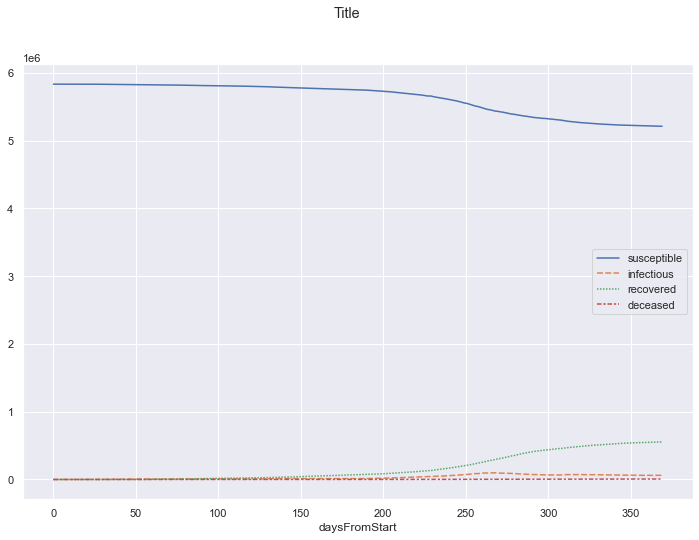

In [9]:
plt.suptitle("Title")
sb.lineplot(data=data)
plt.show()


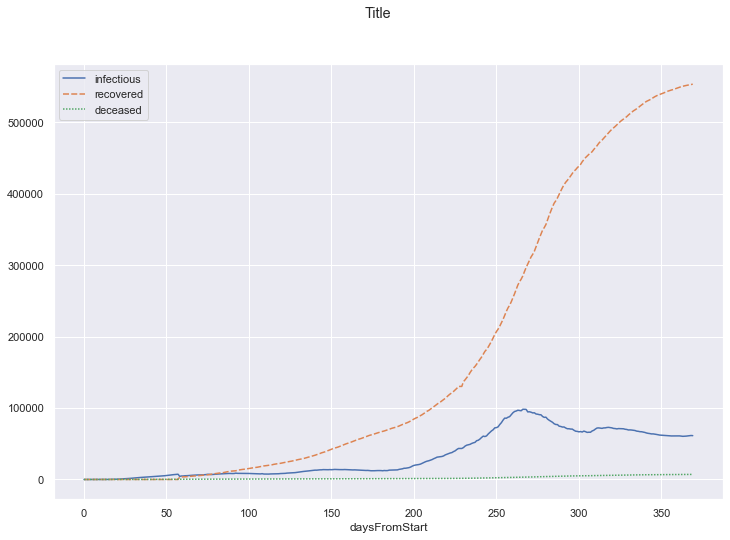

In [10]:
plt.suptitle("Title")
sb.lineplot(data=data[["infectious", "recovered", "deceased"]])
plt.show()


## Data Preparation

In [11]:
date1 = datetime(2020, 4, 30)
date2 = datetime(2020, 3, 7) + timedelta(days=265)
date3 = datetime(2021, 3, 8)

print(f"date1 = {date1.date()}")
print(f"date2 = {date2.date()}")
print(f"date3 = {date3.date()}")


date1 = 2020-04-30
date2 = 2020-11-27
date3 = 2021-03-08


In [12]:
def filter_data(data, start=None, end=None):
    filtered = data.reset_index().sort_values("date")
    if start: filtered = filtered[filtered["date"] >= start]
    if end: filtered = filtered[filtered["date"] < end]
    filtered.loc[:, "daysFromStart"] -= filtered.iloc[0]["daysFromStart"]
    filtered.set_index("daysFromStart", inplace=True)
    return filtered

data1 = filter_data(data, start=date1, end=date2)
data1


,date,susceptible,infectious,recovered,deceased
daysFromStart,,,,,
0,2020-04-30,5824603,4384,3352,316
1,2020-05-01,5824105,4871,3352,327
2,2020-05-02,5823735,4888,3698,334
3,2020-05-03,5823428,5165,3723,339
4,2020-05-04,5823117,5225,3973,340
...,...,...,...,...,...
206,2020-11-22,5456417,96514,276574,3150
207,2020-11-23,5452962,96177,280358,3158
208,2020-11-24,5446214,98266,284903,3272


In [13]:
def get_SIRD_vars(data):
    t = data.index.to_numpy(dtype=int)
    arr = data.to_numpy(dtype=int)
    _, S, I, R, D = arr.T  # leave the date out
    y = np.column_stack((S, I, R, D))
    return t, y

t1, y1 = get_SIRD_vars(data1)
print(f"t1: {t1.shape}\ty1: {y1.shape}")


t1: (211,)	y1: (211, 4)


## Machine Learning

The SIRD model:

$\left\{
\begin{array}{rcl}
\dfrac{\strut dS}{\strut dt} & = & - \dfrac{\strut \beta I S}{\strut N}, \\
\dfrac{\strut dI}{\strut dt} & = & \dfrac{\strut \beta I S}{\strut N} - \gamma I - \mu I, \\
\dfrac{\strut dR}{\strut dt} & = & \gamma I, \\
\dfrac{\strut dD}{\strut dt} & = & \mu I.
\end{array}
\right.$


In [14]:
def SIRD(t, y, beta, gamma, mu):
    global population
    N = population
    S, I, R, D = y
    dS_dt = - beta * I * S / N
    dI_dt =   beta * I * S / N - gamma * I - mu * I
    dR_dt =   gamma * I
    dD_dt =   mu * I
    return (dS_dt, dI_dt, dR_dt, dD_dt)


In [15]:
def loss(k, t, y):
    global iter_
    S, I, R, D = y.T
    sol = solve_ivp(fun=SIRD, t_span=(t[0], t[-1]), y0=y[0], t_eval=t, dense_output=True, args=k)
    S_sol, I_sol, R_sol, D_sol = sol.y
    mse = np.sum(((S_sol - S) ** 2, (I_sol - I) ** 2, (R_sol - R) ** 2, (D_sol - D) ** 2)) / len(t)
    iter_ += 1
    print(f"Iteration #{'%4d' % iter_}: MSE = {mse}")
    clear_output(wait=True)
    return mse

def fit_model(t, y):
    k0 = (0.1, 0.1, 0.01)  # initial guess values for (beta, gamma, mu)
    bounds = ((1e-4, 0.3), (1e-4, 0.3), (1e-4, 0.1))  # bounds for (beta, gamma, and mu)
    return minimize(fun=loss, x0=k0, args=(t, y), bounds=bounds, method="Powell")  # other methods include: "TNC"


In [16]:
class fit_res:
    """A collection of SIRD fitting results."""

    def __init__(self, t, y):
        global iter_
        iter_ = 0
        self.t = t
        self.y = y
        self.fit = fit_model(t, y)
        self.iter = iter_
        self.mse = self.fit.fun
    
    def __repr__(self):
        return str(f"Fitting completed within {self.iter} iterations.\n" \
                   f"{self.fit}")


In [17]:
res1 = fit_res(t1, y1)
res1


Fitting completed within 514 iterations.
   direc: array([[-0.00754372, -0.00630334, -0.00241302],
       [-0.04073516, -0.04654533,  0.00239027],
       [-0.00966897, -0.00453796, -0.00578777]])
     fun: 403491334.2248718
 message: 'Optimization terminated successfully.'
    nfev: 514
     nit: 10
  status: 0
 success: True
       x: array([0.05474518, 0.03888967, 0.00010037])

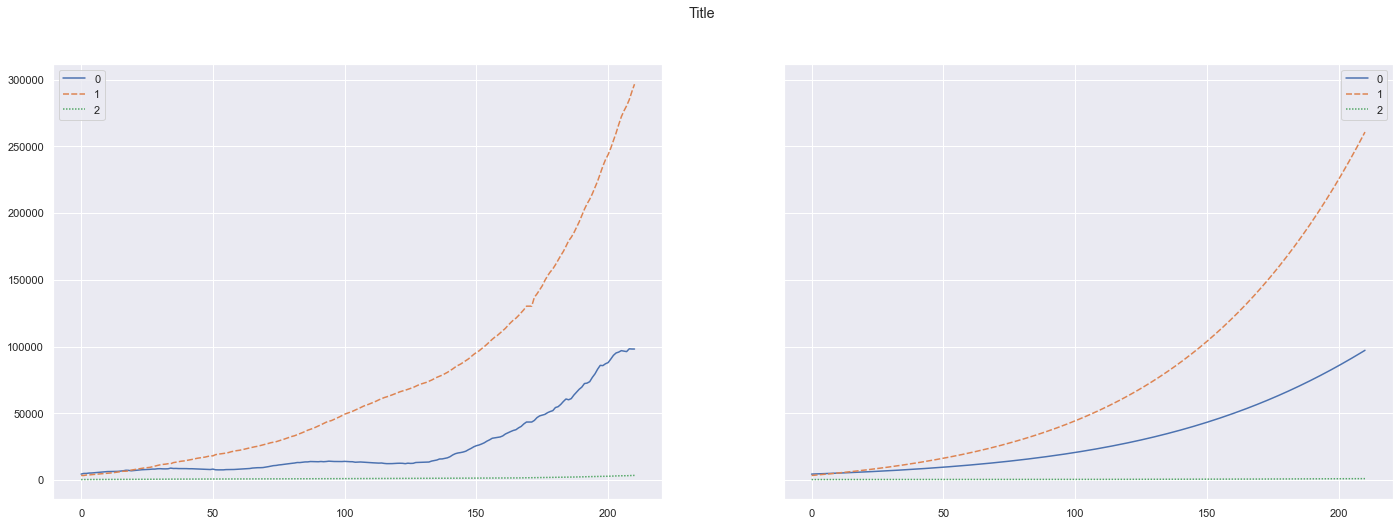

In [18]:
y1_res = np.array(solve_ivp(fun=SIRD, t_span=(res1.t[0], res1.t[-1]), y0=res1.y[0], t_eval=res1.t, dense_output=True, args=(res1.fit.x)).y).T
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(24, 8))
plt.suptitle("Title")
sb.lineplot(data=res1.y.T[1:].T, ax=axs[0])
sb.lineplot(data=y1_res.T[1:].T, ax=axs[1])
plt.show()


In [19]:
def fit(data, start=None, end=None):
    filtered = filter_data(data, start, end)
    t, y = get_SIRD_vars(filtered)
    res = fit_res(t, y)
    return res


In [20]:
res2 = fit(data, start=date2, end=date3)
res2


Fitting completed within 395 iterations.
   direc: array([[-1.85116765e-02, -2.88748445e-02, -1.29398268e-10],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-5.94297857e-05, -3.40094478e-05, -5.89485339e-05]])
     fun: 578308999.874522
 message: 'Optimization terminated successfully.'
    nfev: 395
     nit: 8
  status: 0
 success: True
       x: array([0.04197676, 0.04564079, 0.00149454])

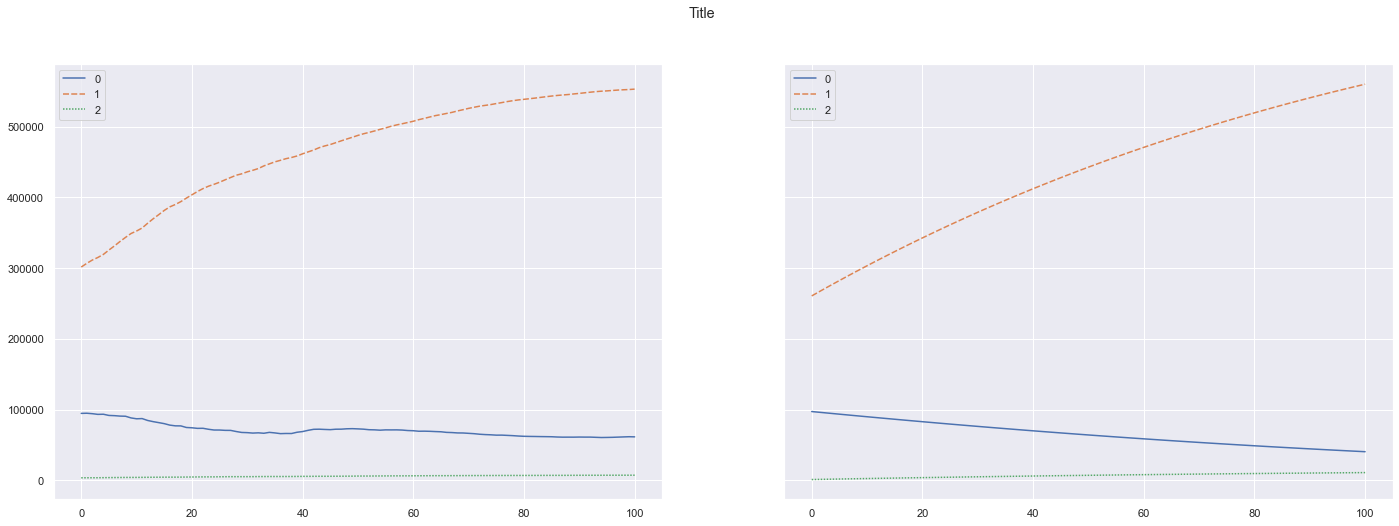

In [21]:
y2_res = np.array(solve_ivp(fun=SIRD, t_span=(res2.t[0], res2.t[-1]), y0=y1_res[-1], t_eval=res2.t, dense_output=True, args=(res2.fit.x)).y).T
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(24, 8))
plt.suptitle("Title")
sb.lineplot(data=res2.y.T[1:].T, ax=axs[0])
sb.lineplot(data=y2_res.T[1:].T, ax=axs[1])
plt.show()


In [22]:
y_res = np.concatenate([y1_res, y2_res])
y_res.shape


(312, 4)

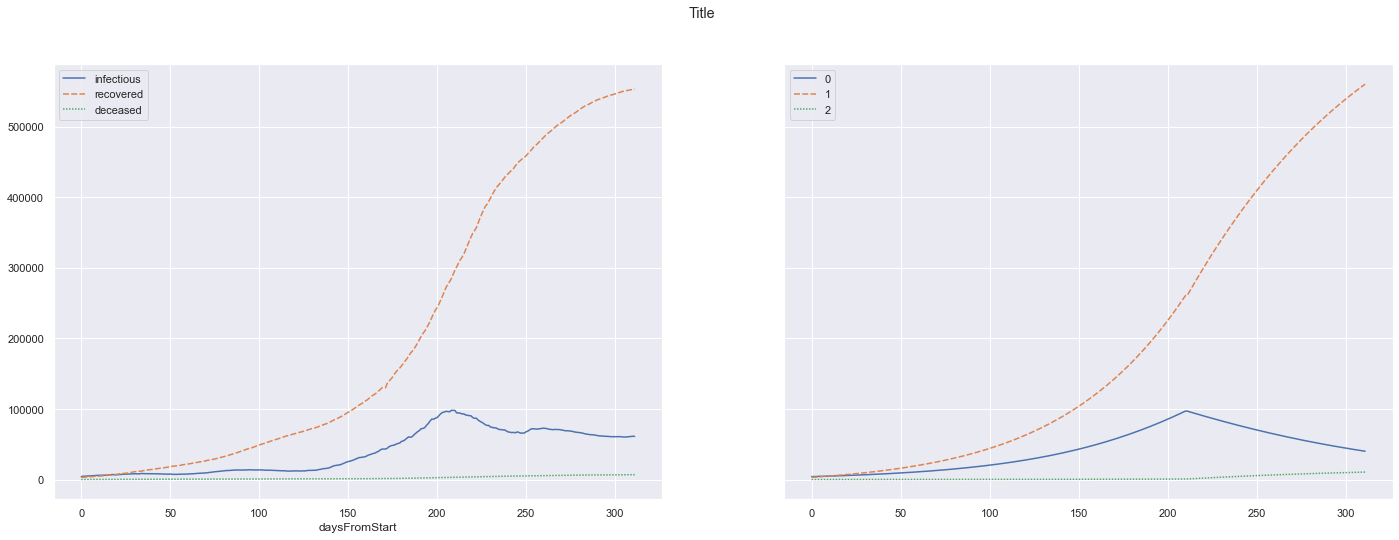

In [23]:
y = filter_data(data, start=date1, end=date3)
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(24, 8))
plt.suptitle("Title")
sb.lineplot(data=y[["infectious", "recovered", "deceased"]], ax=axs[0])
sb.lineplot(data=y_res.T[1:].T, ax=axs[1])
plt.show()
